In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import glob
import re
import gc

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from dask.distributed import Client
from IPython.display import IFrame

from tqdm.notebook import tqdm

from skimage.transform import ProjectiveTransform, AffineTransform, EuclideanTransform, warp
from sklearn.linear_model import (LinearRegression,
                                  TheilSenRegressor,
                                  RANSACRegressor,
                                  HuberRegressor,
                                  RidgeCV,
                                  LassoCV)
import mrcfile
try:
    import skimage.external.tifffile as tiff
except:
    import tifffile as tiff

from SIFT_gs.FIBSEM_SIFT_gs import FIBSEM_frame, FIBSEM_dataset
from SIFT_gs.FIBSEM_SIFT_gs import get_min_max_thresholds
from SIFT_gs.FIBSEM_SIFT_gs import (ShiftTransform,
                                    XScaleShiftTransform,
                                    ScaleShiftTransform,
                                    RegularizedAffineTransform)
            
from SIFT_gs.FIBSEM_SIFT_gs import (generate_report_mill_rate_xlsx,
                                    generate_report_FOV_center_shift_xlsx,
                                    generate_report_data_minmax_xlsx,
                                    generate_report_ScanRate_EHT_xlsx,
                                    generate_report_transf_matrix_from_xlsx,
                                    generate_report_from_xls_registration_summary,
                                    plot_registrtion_quality_xlsx,
                                    read_kwargs_xlsx)
                        
from SIFT_gs.FIBSEM_SIFT_gs import plot_cross_sections_mrc_stack, add_scale_bar
from SIFT_gs.FIBSEM_SIFT_gs import (bin_crop_mrc_stack,
                                    show_eval_box_mrc_stack)
from SIFT_gs.FIBSEM_SIFT_gs import plot_2D_blob_results, plot_2D_blob_examples
from SIFT_gs.FIBSEM_SIFT_gs import build_kernel_FFT_zero_destreaker_XY, build_kernel_FFT_zero_destreaker_radii_angles
from SIFT_gs.FIBSEM_SIFT_gs import (destreak_mrc_stack_with_kernel,
                                    destreak_single_frame_kernel_shared,
                                    smooth_mrc_stack_with_kernel)

Open CV version:  4.6.0
SIFT_gs version:  4.0.1


In [2]:
#start / restart client
try:
    client.restart()
except:
    client = Client()
    
# setup a window to monitor the client progress
try:
    dport = client.scheduler_info()['services']['dashboard']
except:
    dport = client.scheduler_info()['services']['bokeh']
print('Using Local Port:   ', dport)
status_update_address0 = 'http://localhost:{:d}/status'.format(dport)
print('Use ' + status_update_address0 +' to monitor DASK progress')
status_update_address = 'http://localhost:{:d}/status'.format(dport)
IFrame(src=status_update_address, width='100%', height='900px')

C:\Users\labadmin\Miniconda3\envs\sandbox\lib\site-packages\distributed\bokeh\core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Using Local Port:    49964
Use http://localhost:49964/status to monitor DASK progress


In [ ]:
orig_mrc = os.path.normpath('Y:\Images Jeiss8\Cryo\Y2023\PDC_WTDN_ROI2\PDC_WTDN_ROI2_4x4x4nm_v2.mrc')
images, axs = plot_cross_sections_mrc_stack(orig_mrc,
                                            bar_width = 3,
                                            bar_length_um = 5,
                                            label_offset = 100,
                                            label_font_size = 8.0,
                                            EM_max = 850, 
                                            dpi=300)

# Destreaking Example

array([ 599.09765625, 4179.90234375])

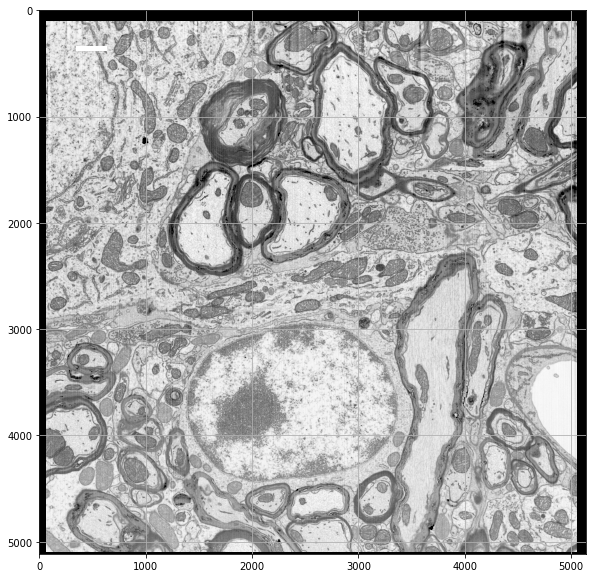

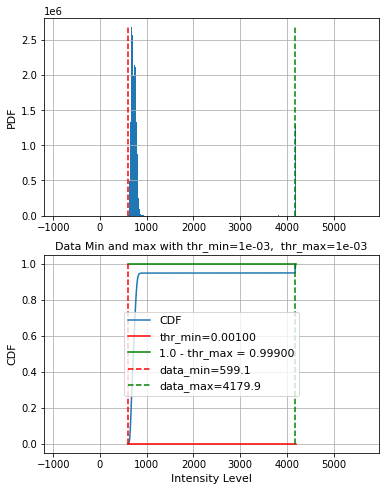

In [3]:
orig_mrc = os.path.normpath('Y:\Images Jeiss8\Cryo\Y2023\PDC_WTDN_ROI2\PDC_WTDN_ROI2_4x4x4nm_v2.mrc')
mrc_obj = mrcfile.mmap(orig_mrc, mode='r', permissive=True)
header = mrc_obj.header
'''
    mode 0 -> uint8
    mode 1 -> int16
    mode 2 -> float32
    mode 4 -> complex64
    mode 6 -> uint16
'''
mrc_mode = mrc_obj.header.mode
test_frame_ind = 763
test_frame = mrc_obj.data[test_frame_ind, :, :]
mrc_obj.close()

vmin, vmax = get_min_max_thresholds(test_frame[200: -200, 200: -200], disp_res=False)
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(test_frame, cmap='Greys', vmin=vmin, vmax=vmax)
ax.grid(True)
#ax.axis(False)
#ax.axis(False)
add_scale_bar(ax, pixel=0.004, bar_length=5.0, bar_width=5, bar_label='')

get_min_max_thresholds(test_frame)

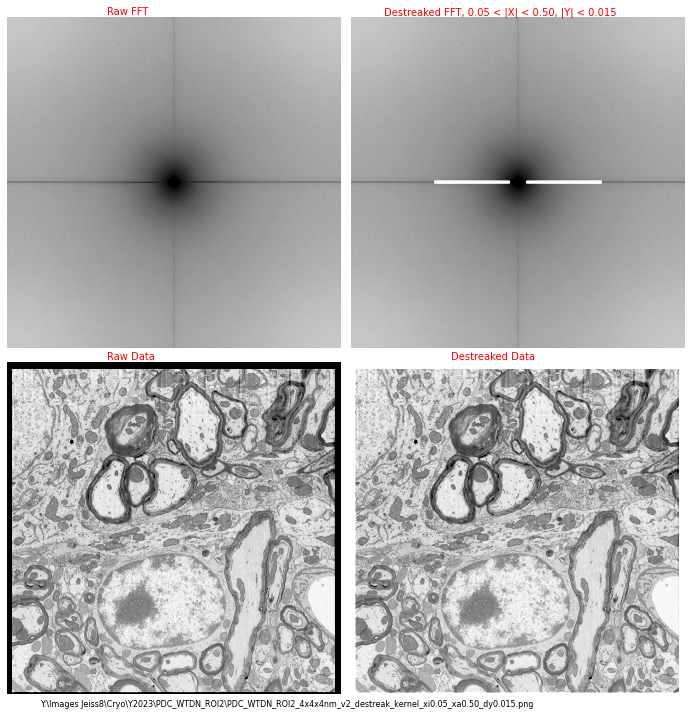

In [4]:
# define the destreak_kernel and estimate the performance

destreak_kernel_XY = True

if destreak_kernel_XY:   # destreaking isperformed by zeroing FFT data inside two symmetric bands along X-axis in FFT space
    xstart = 0.05
    xstop = 0.5
    dy = 0.015
else:                    # destreaking isperformed by zeroing FFT data inside angular segments FFT space (also limited in radial FFT coordinate)
    astart = -1.0
    astop = 1.0
    rstart = 0.05
    rstop = 0.5
    symmetry = 2

data_min = 500
data_max = 1500

clip_mask = (test_frame>data_min)*(test_frame<data_max)
ny, nx = np.shape(clip_mask)
try:
    yi = np.min(np.where(clip_mask[:, nx//2]))
except:
    yi = 0
try:
    ya = ny-np.max(np.where(clip_mask[:, nx//2]))
except:
    ya = 1
try:
    xi = np.min(np.where(clip_mask[ny//2, :]))
except:
    xi = 0
try:
    xa = nx-np.max(np.where(clip_mask[ny//2, :]))
except:
    xa = 1
pad_width = np.max((xi, xa, yi, ya))
padded_fr = clip_mask*test_frame + (1-clip_mask)*np.pad(test_frame[pad_width:-pad_width, pad_width:-pad_width], pad_width = pad_width, mode='symmetric')
img_fft = np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(padded_fr)))

if destreak_kernel_XY:
    destreak_kernel = build_kernel_FFT_zero_destreaker_XY(img_fft,
                                                          xstart=xstart,
                                                          xstop=xstop,
                                                          dy = dy)

else:
    destreak_kernel = build_kernel_FFT_zero_destreaker_radii_angles(img_fft,
                                       astart = astart,
                                       astop = astop,
                                       rstart=rstart,
                                       rstop=rstop,
                                       symm=symmetry)
    
st = 1.0/np.sqrt(2.0)
kernel = np.array([[st, 1.0, st],[1.0,1.0,1.0], [st, 1.0, st]]).astype(float)
smooth_kernel = kernel/kernel.sum()

data_FT_abs = np.log(np.abs(img_fft))
vmin_FFT, vmax_FFT = get_min_max_thresholds(data_FT_abs, disp_res=False)

data_FT_abs_zr = data_FT_abs * destreak_kernel

params = [orig_mrc, type(test_frame[0, 0]), test_frame_ind, test_frame_ind, data_min, data_max]
j, destreaked_frame = destreak_single_frame_kernel_shared(destreak_kernel, params)

sx = 10
sy = sx * ny // nx + 1.5

fig, axs = plt.subplots(2,2, figsize=(sx, sy))
fig.subplots_adjust(left=0.03, bottom=0.07, right=0.97, top=0.97, wspace=0.03, hspace=0.03)

axs[0, 0].imshow(data_FT_abs, cmap='Greys', vmin=vmin_FFT, vmax=vmax_FFT)
axs[0, 0].text(0.3, 1.005, 'Raw FFT', color='red', transform=axs[0, 0].transAxes, fontsize=10)

if destreak_kernel_XY:
    lim_str1 = '{:.2f} < |X| < {:.2f}, |Y| < {:.3f}'.format(xstart, xstop, dy)
    lim_str2 = '_xi{:.2f}_xa{:.2f}_dy{:.3f}.png'.format(xstart, xstop, dy)
else:
    lim_str1 = '{:.1f} < α < {:.1f}, {:.2f} < R < {:.2f}, symm={:d}'.format(astart, astop, rstart, rstop, symmetry)
    lim_str2 = '_ai{:.1f}_aa{:.1f}_ri{:.2f}_ra{:.2f}_symm{:d}.png'.format(astart, astop, rstart, rstop, symmetry)

axs[0, 1].imshow(data_FT_abs_zr, cmap='Greys', vmin=vmin_FFT, vmax=vmax_FFT)
axs[0, 1].text(0.1, 1.005, 'Destreaked FFT, '+lim_str1, color='red', transform=axs[0, 1].transAxes, fontsize=10)

vmin_ds, vmax_ds = get_min_max_thresholds(destreaked_frame[200: -200, 200: -200], disp_res=False)
axs[1, 1].imshow(destreaked_frame, cmap='Greys', vmin=vmin_ds, vmax=vmax_ds)
axs[1, 1].text(0.3, 1.005, 'Destreaked Data', color='red', transform=axs[1, 1].transAxes, fontsize=10)

axs[1, 0].imshow(test_frame, cmap='Greys', vmin=vmin, vmax=vmax, zorder=10)
axs[1, 0].text(0.3, 1.005, 'Raw Data', color='red', transform=axs[1,0].transAxes, fontsize=10)

for ax in axs.ravel():
    ax.axis(False)

save_png_name = orig_mrc.replace('.mrc', '_destreak_kernel'+lim_str2)
axs[1, 1].text(0.1, -0.04, save_png_name, transform=axs[1, 0].transAxes, fontsize=8)
fig.savefig(save_png_name, dpi=600)

In [5]:
%%time
destreaked_mrc = orig_mrc.replace('.mrc', '_destreaked_test.mrc')
saved_destreak_filename =  destreak_mrc_stack_with_kernel(orig_mrc,
                                                          destreak_kernel,
                                                          data_min, data_max,
                                                          DASK_client = client,
                                                          max_futures = 2000,
                                                          save_filename = destreaked_mrc)
print(time.strftime('%Y/%m/%d  %H:%M:%S')+'   Destreaked data saved into: ', saved_destreak_filename)

DASK client exists. Will perform distributed computations
Use http://localhost:49964/status to monitor DASK progress
Source mrc_mode: 1, source data type: <class 'numpy.int16'>
Source Data Shape:  5143 x 5114 x 2899
Source Voxel Size (Angstroms): 39.999279 x 39.999279 x 43.768425
Result mrc_mode: 1, source data type: <class 'numpy.int16'>
New Data Shape:  5143 x 5114 x 2899
Result Voxel Size (Angstroms): 39.999279 x 39.999279 x 43.768425


Creating params list:   0%|          | 0/2899 [00:00<?, ?it/s]

2024/06/05  10:32:35   Using DASK distributed
2024/06/05  10:32:37   Starting DASK batch 1 with 2000 jobs, 899 jobs remaining
2024/06/05  11:27:54   Starting DASK batch 1 with 899 jobs
2024/06/05  11:58:12   Destreaked data saved into:  Y:\Images Jeiss8\Cryo\Y2023\PDC_WTDN_ROI2\PDC_WTDN_ROI2_4x4x4nm_v2_destreaked_test.mrc
Wall time: 1h 42min 15s


In [ ]:
images, axs = plot_cross_sections_mrc_stack(destreaked_mrc,
                                            bar_width = 3,
                                            bar_length_um = 5,
                                            label_offset = 100,
                                            label_font_size = 8.0,
                                            EM_max = 850, 
                                            dpi=300)

# Smoothing Example

array([  0.      , 862.640625])

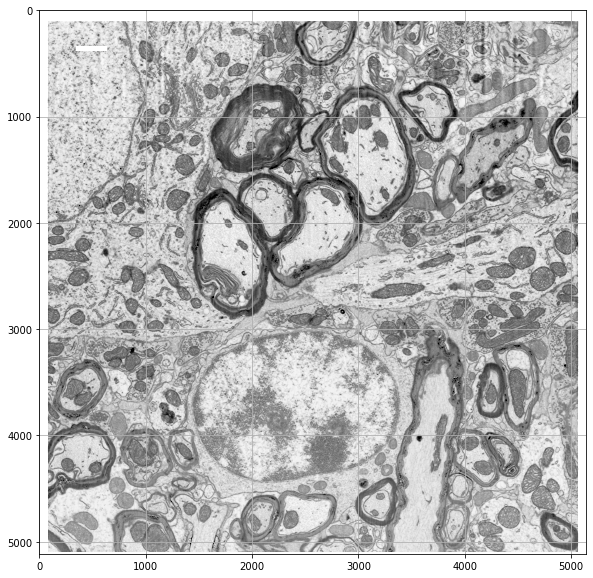

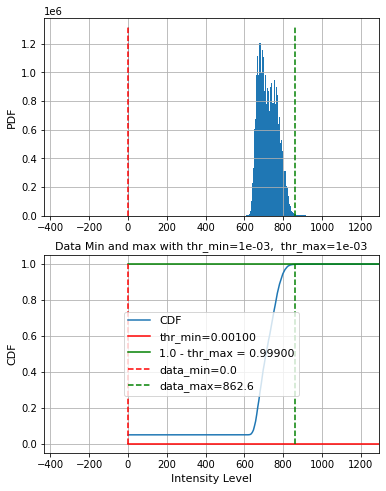

In [7]:
mrc_obj = mrcfile.mmap(destreaked_mrc, mode='r', permissive=True)
header = mrc_obj.header
'''
    mode 0 -> uint8
    mode 1 -> int16
    mode 2 -> float32
    mode 4 -> complex64
    mode 6 -> uint16
'''
mrc_mode = mrc_obj.header.mode
test_frame_ind = 1000
test_frame = mrc_obj.data[test_frame_ind, :, :]
mrc_obj.close()

vmin, vmax = get_min_max_thresholds(test_frame[200: -200, 200: -200], disp_res=False)
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(test_frame, cmap='Greys', vmin=vmin, vmax=vmax)
ax.grid(True)
#ax.axis(False)
#ax.axis(False)
add_scale_bar(ax, pixel=0.004, bar_length=5.0, bar_width=5, bar_label='')

get_min_max_thresholds(test_frame)

In [8]:
%%time
st = 1.0/np.sqrt(2.0)
kernel = np.array([[st, 1.0, st],[1.0,1.0,1.0], [st, 1.0, st]]).astype(float)
smooth_kernel = kernel/kernel.sum()

smoothed_mrc = destreaked_mrc.replace('_test.mrc', '_smoothed_test.mrc')
data_min = 500
data_max = 1500
saved_smooth_filename =  smooth_mrc_stack_with_kernel(destreaked_mrc,
                                                      smooth_kernel,
                                                      data_min, data_max,
                                                      DASK_client = client,
                                                      max_futures = 2000,
                                                      save_filename = smoothed_mrc)
print(time.strftime('%Y/%m/%d  %H:%M:%S')+'   Smoothed data saved into: ', saved_smooth_filename)

DASK client exists. Will perform distributed computations
Use http://localhost:49964/status to monitor DASK progress
Source mrc_mode: 1, source data type: <class 'numpy.int16'>
Source Data Shape:  5143 x 5114 x 2899
Source Voxel Size (Angstroms): 39.999279 x 39.999279 x 43.768425
Result mrc_mode: 1, source data type: <class 'numpy.int16'>
New Data Shape:  5143 x 5114 x 2899
Result Voxel Size (Angstroms): 39.999279 x 39.999279 x 43.768425


Creating params list:   0%|          | 0/2899 [00:00<?, ?it/s]

2024/06/05  13:21:59   Using DASK distributed
2024/06/05  13:21:59   Starting DASK batch 1 with 2000 jobs, 899 jobs remaining
2024/06/05  13:57:33   Starting DASK batch 1 with 899 jobs
2024/06/05  14:22:17   Smoothed data saved into:  Y:\Images Jeiss8\Cryo\Y2023\PDC_WTDN_ROI2\PDC_WTDN_ROI2_4x4x4nm_v2_destreaked_smoothed_test.mrc
Wall time: 1h 16min 42s


In [ ]:
images, axs = plot_cross_sections_mrc_stack(saved_smooth_filename,
                                            bar_width = 3,
                                            bar_length_um = 5,
                                            label_offset = 30,
                                            label_font_size = 8.0,
                                            EM_max = 850,
                                            dpi=300)

2024/06/05  14:37:15   EM cross-sections dimensions (um): [20.5716292  20.45563129 12.6884664 ]
Center coordinates (um): [10.2858146  10.22781565  6.3442332 ]


Loading EM Cross-sections Data:   0%|          | 0/3 [00:00<?, ?it/s]

2024/06/05  14:37:16   X-Y cross-section loaded, dimensions (pixels): 5143 5114
2024/06/05  14:37:27   X-Z cross-section loaded, dimensions (pixels): 5143 2899
